In [1]:
from pyspark.sql import SparkSession


In [2]:
spark = SparkSession.builder \
    .appName("Negative Sentiment Time Series") \
    .getOrCreate()


24/12/07 09:10:09 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
# Parquet file to a DataFrame

df = spark.read.parquet("/home/ymusic7/metro_restaurants/balanced_reviews.parquet")


In [13]:
df.head()

Row(name='Sushi Avenue', lat=33.864809699999995, lon=-84.0164532, text="This restaurant is so amazing as the food is so delicious and the staff are super friendly too! I can't wait to return!Thank you so much, Fumiko! You made our night!We came to celebrate a birthday and they (Sushi Avenue) did not disappoint.We started with the best fried oysters I have ever had. They were perfectly, lightly seasoned and light fried golden brown then served with two amazing sauces. The seaweed salad was so fresh. 2 orders of yummy miss soup.Please know their salmon stuffed mushrooms are outstanding!!! Two orders jalapeños poppers were poppin! Three orders of terrific Avocado and Cucumber rolls. We also loved the teriyaki shrimp entree. We enjoyed their green tea with lemon.  We finished all of this with the sensational Green Tea Cheesecake. Beautiful and tasty too!Everything was just perfect!!!!#PinchofButter", date='2022-12-12 02:02:01', score=5, keyword='japanese restaurant', addr='2118 Scenic Hwy 

In [5]:
from nltk.corpus import stopwords
print(stopwords.words('english')[:10])  # Print the first 10 stopwords



['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [6]:
import pandas as pd
import nltk
from pyspark.sql.functions import col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer
from pyspark.sql import SparkSession

# Clean the 'text' column (remove special characters, URLs, etc.)
df_cleaned = df.withColumn("cleaned_text", 
                          regexp_replace(col("text"), r'[^a-zA-Z\s]', '').alias('cleaned_text'))

# Tokenize the text into words
tokenizer = Tokenizer(inputCol="cleaned_text", outputCol="words")
df_tokenized = tokenizer.transform(df_cleaned)

# Remove stopwords using NLTK's list
stop_words = stopwords.words('english')

# Remove stopwords from tokenized words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=stop_words)
df_filtered = remover.transform(df_tokenized)

# Show the resulting filtered words (after stopwords are removed)
df_filtered.select("filtered_words").show(truncate=False)



+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|filtered_words                                                                                                                                                                                                              

In [7]:
from pyspark.sql.functions import year, month, col

# Convert the 'date' column to a timestamp type (if it's not already)
df_filtered = df_filtered.withColumn('date', col('date').cast('timestamp'))

# Extract year and month from the 'date' column
df_filtered = df_filtered.withColumn('year', year(col('date')))
df_filtered = df_filtered.withColumn('month', month(col('date')))


In [10]:
from pyspark.sql import functions as F

# Assuming df is your original DataFrame
# Extract year and month from the 'date' column
df_with_date = df.withColumn("year", F.year("date")) \
                 .withColumn("month", F.month("date"))

# Filter for Japanese and Chinese restaurants
df_filtered = df_with_date.filter(df_with_date['keyword'].isin(['japanese restaurant', 'chinese restaurant']))

# Count reviews yearly for both cuisines
df_yearly = df_filtered.groupBy("year", "keyword") \
                       .agg(F.count("text").alias("count")) \
                       .orderBy("year")

# Count reviews monthly from 2019 to 2024 for both cuisines
df_monthly_recent = df_filtered.filter((df_filtered["year"] >= 2019) & (df_filtered["year"] <= 2024)) \
                                .groupBy("year", "month", "keyword") \
                                .agg(F.count("text").alias("count")) \
                                .orderBy("year", "month")

# Convert to Pandas for plotting
df_yearly_pandas = df_yearly.toPandas()
df_monthly_recent_pandas = df_monthly_recent.toPandas()


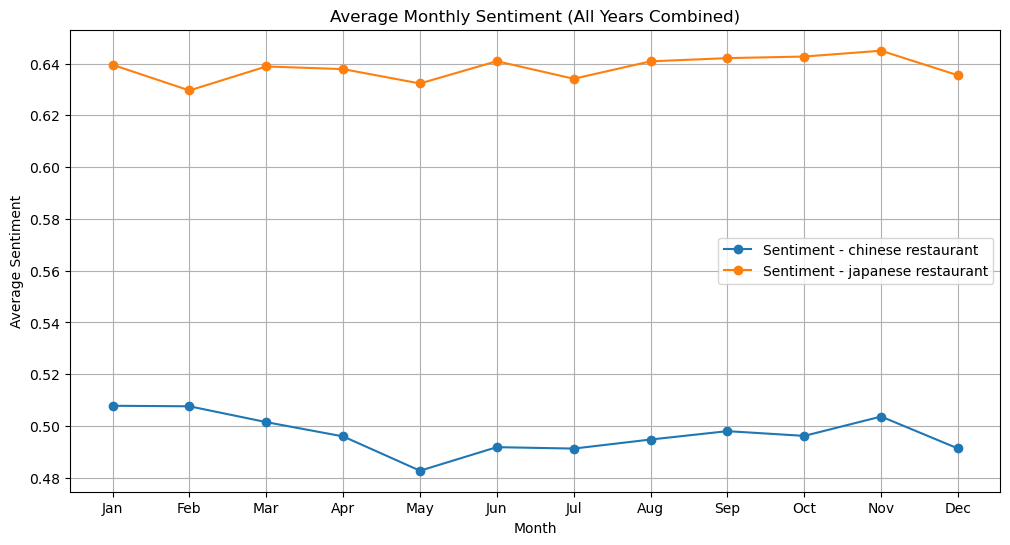

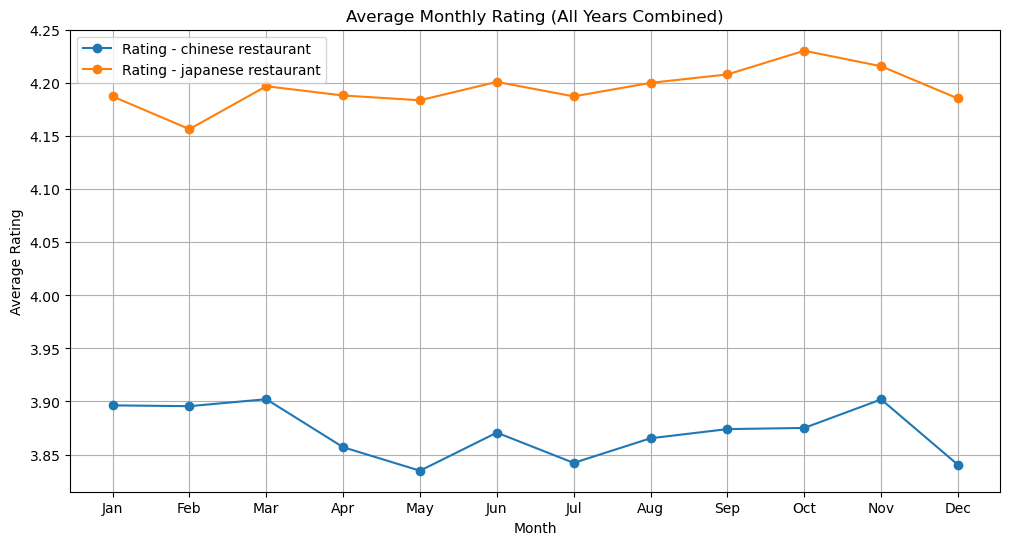

In [22]:
from pyspark.sql.functions import avg, month
import pandas as pd
import matplotlib.pyplot as plt

# Group by month and keyword, ignoring year
df_monthly_avg = df_cleaned.groupBy("month", "keyword").agg(
    avg("sentiment").alias("avg_sentiment"),
    avg("score").alias("avg_rating")
)

# Convert to Pandas
df_monthly_avg_pd = df_monthly_avg.toPandas()

# Sort by month for correct ordering
df_monthly_avg_pd = df_monthly_avg_pd.sort_values("month")

# Plot the average sentiment by month
plt.figure(figsize=(12, 6))
for keyword in df_monthly_avg_pd['keyword'].unique():
    subset = df_monthly_avg_pd[df_monthly_avg_pd['keyword'] == keyword]
    plt.plot(subset['month'], subset['avg_sentiment'], marker='o', label=f"Sentiment - {keyword}")
plt.title("Average Monthly Sentiment (All Years Combined)")
plt.xlabel("Month")
plt.ylabel("Average Sentiment")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)

# Plot the average rating by month
plt.figure(figsize=(12, 6))
for keyword in df_monthly_avg_pd['keyword'].unique():
    subset = df_monthly_avg_pd[df_monthly_avg_pd['keyword'] == keyword]
    plt.plot(subset['month'], subset['avg_rating'], marker='o', label=f"Rating - {keyword}")
plt.title("Average Monthly Rating (All Years Combined)")
plt.xlabel("Month")
plt.ylabel("Average Rating")
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)

plt.show()


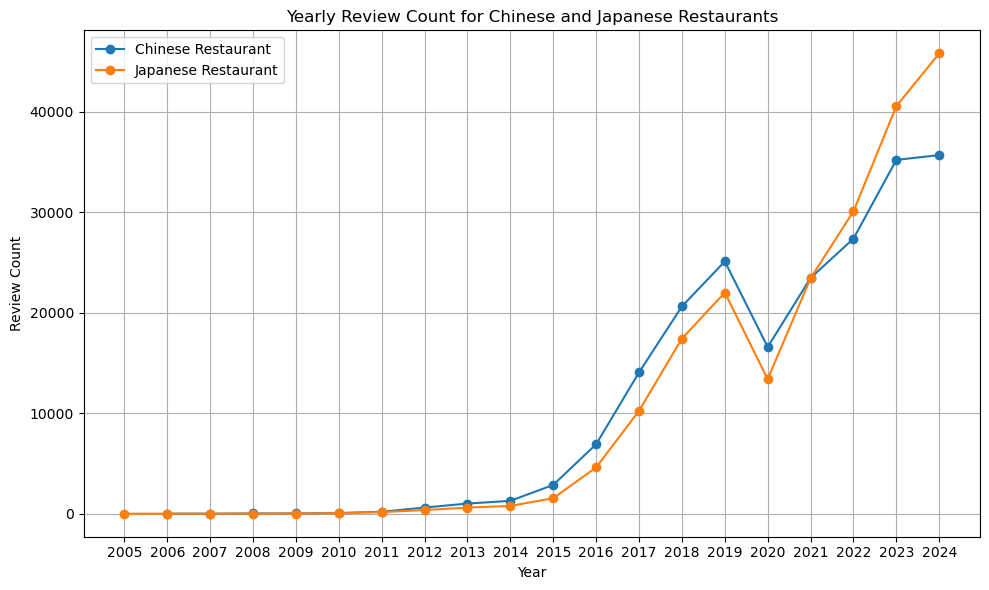

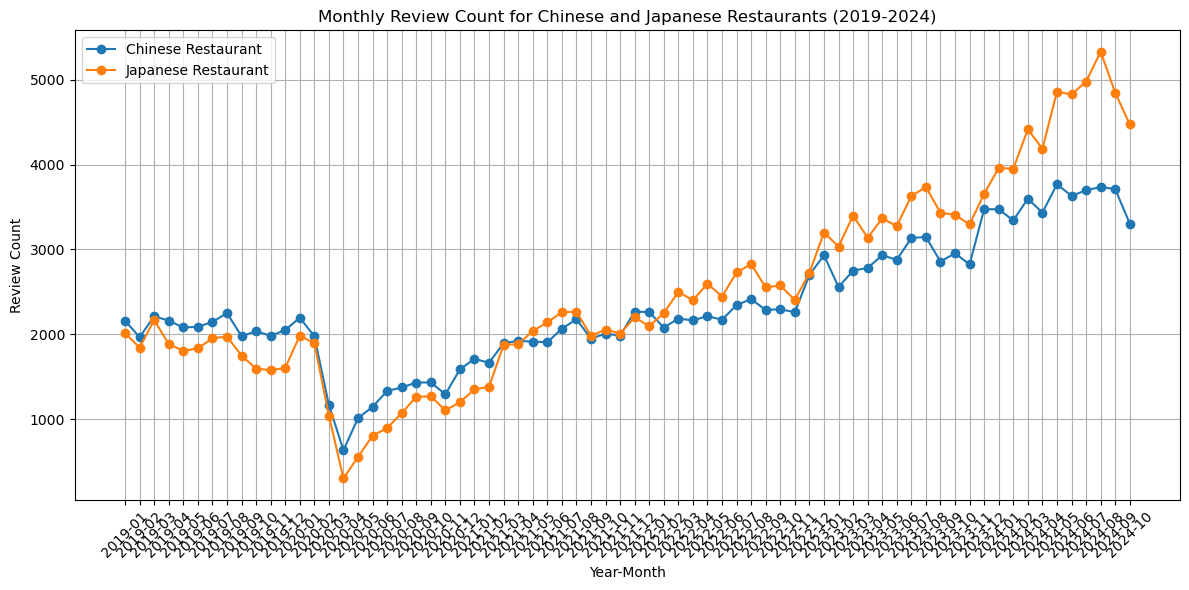

In [12]:
import matplotlib.pyplot as plt
import pandas as pd



df_yearly_pivot = df_yearly_pandas.pivot_table(index="year", columns="keyword", values="count", aggfunc="sum")

# Plot yearly data
plt.figure(figsize=(10, 6))
plt.plot(df_yearly_pivot.index, df_yearly_pivot['chinese restaurant'], label='Chinese Restaurant', marker='o')
plt.plot(df_yearly_pivot.index, df_yearly_pivot['japanese restaurant'], label='Japanese Restaurant', marker='o')
plt.title('Yearly Review Count for Chinese and Japanese Restaurants')
plt.xlabel('Year')
plt.ylabel('Review Count')

#  x-axis shows integer years
plt.xticks(df_yearly_pivot.index.astype(int))  # Convert index (year) to integers

plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('yearly_review_counts.png')
plt.show()


#  monthly data for easier plotting
df_monthly_recent_pivot = df_monthly_recent_pandas.pivot_table(
    index=["year", "month"], columns="keyword", values="count", aggfunc="sum"
)

# combine year and month for x-axis labels
df_monthly_recent_pivot.index = df_monthly_recent_pivot.index.map(lambda x: f"{x[0]}-{x[1]:02d}")

# plot monthly data
plt.figure(figsize=(12, 6))
plt.plot(df_monthly_recent_pivot.index, df_monthly_recent_pivot['chinese restaurant'], label='Chinese Restaurant', marker='o')
plt.plot(df_monthly_recent_pivot.index, df_monthly_recent_pivot['japanese restaurant'], label='Japanese Restaurant', marker='o')
plt.title('Monthly Review Count for Chinese and Japanese Restaurants (2019-2024)')
plt.xlabel('Year-Month')
plt.ylabel('Review Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('monthly_review_counts_2019_2024.png')
plt.show()


In [27]:
df_cleaned.head()


Row(name='Sushi Avenue', lat=33.864809699999995, lon=-84.0164532, text="This restaurant is so amazing as the food is so delicious and the staff are super friendly too! I can't wait to return!Thank you so much, Fumiko! You made our night!We came to celebrate a birthday and they (Sushi Avenue) did not disappoint.We started with the best fried oysters I have ever had. They were perfectly, lightly seasoned and light fried golden brown then served with two amazing sauces. The seaweed salad was so fresh. 2 orders of yummy miss soup.Please know their salmon stuffed mushrooms are outstanding!!! Two orders jalapeños poppers were poppin! Three orders of terrific Avocado and Cucumber rolls. We also loved the teriyaki shrimp entree. We enjoyed their green tea with lemon.  We finished all of this with the sensational Green Tea Cheesecake. Beautiful and tasty too!Everything was just perfect!!!!#PinchofButter", date='2022-12-12 02:02:01', score=5, keyword='japanese restaurant', addr='2118 Scenic Hwy 

In [8]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment using VADER
def get_vader_sentiment(text):
    return sia.polarity_scores(text)['compound']  # compound score is the overall sentiment score

# Register the UDF with PySpark
vader_sentiment_udf = udf(get_vader_sentiment, FloatType())

# Apply the sentiment analysis to the cleaned text
df_filtered_with_vader_sentiment = df_cleaned.withColumn("sentiment", vader_sentiment_udf(col("cleaned_text")))

# Show the resulting dataframe with sentiment scores
df_filtered_with_vader_sentiment.select("name", "text", "sentiment").show(5, truncate=False)




+---------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|name                       |text                                                                                           

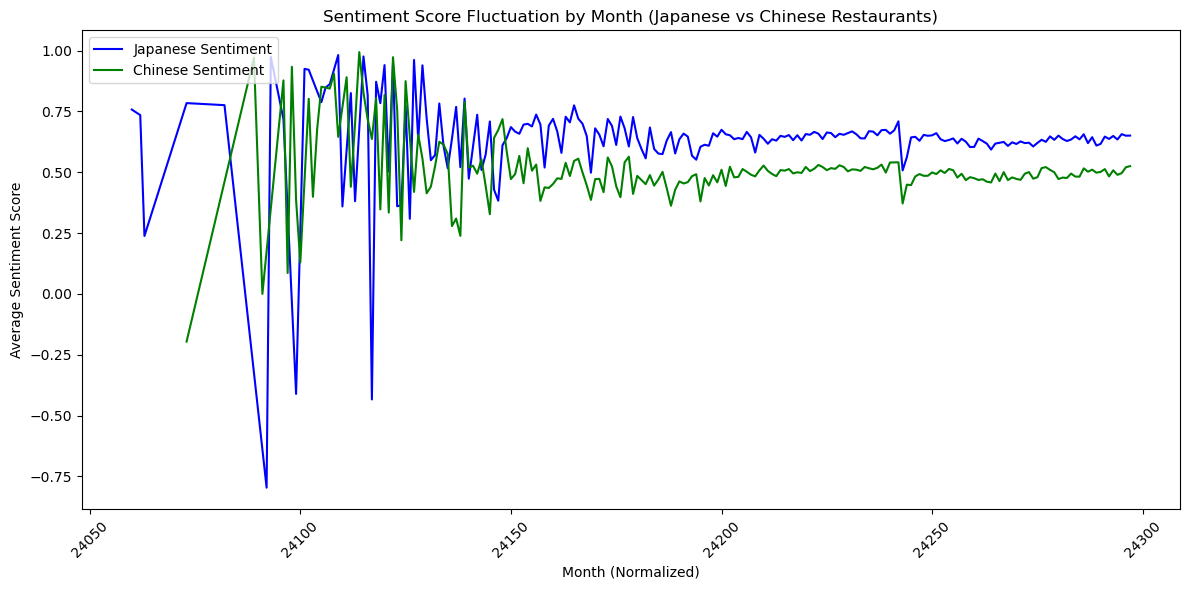

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F

# Step 1: Group by year and month to calculate the average sentiment for each month
df_monthly_sentiment = df_filtered_with_vader_sentiment.groupBy("year", "month", "keyword") \
    .agg(F.avg("sentiment").alias("avg_sentiment")) \
    .filter(df_filtered_with_vader_sentiment['keyword'].isin(['japanese restaurant', 'chinese restaurant'])) \
    .orderBy("year", "month")

# Step 2: Convert to Pandas for easier plotting
df_monthly_sentiment_pandas = df_monthly_sentiment.toPandas()

# Step 3: Normalize months into a continuous series (12 months per year)
df_monthly_sentiment_pandas['month_norm'] = df_monthly_sentiment_pandas['year'] * 12 + df_monthly_sentiment_pandas['month'] - 1

# Step 4: Plot sentiment fluctuation by month for Japanese and Chinese restaurants
plt.figure(figsize=(12, 6))

# Plot sentiment for Japanese restaurants
df_japanese_sentiment = df_monthly_sentiment_pandas[df_monthly_sentiment_pandas['keyword'] == 'japanese restaurant']
plt.plot(df_japanese_sentiment['month_norm'], df_japanese_sentiment['avg_sentiment'], label="Japanese Sentiment", color='blue')

# Plot sentiment for Chinese restaurants
df_chinese_sentiment = df_monthly_sentiment_pandas[df_monthly_sentiment_pandas['keyword'] == 'chinese restaurant']
plt.plot(df_chinese_sentiment['month_norm'], df_chinese_sentiment['avg_sentiment'], label="Chinese Sentiment", color='green')

# Step 5: Customize the plot
plt.title("Sentiment Score Fluctuation by Month (Japanese vs Chinese Restaurants)")
plt.xlabel("Month (Normalized)")
plt.ylabel("Average Sentiment Score")
plt.xticks(rotation=45)
plt.legend(loc="upper left")
plt.tight_layout()

# Show the plot
plt.show()


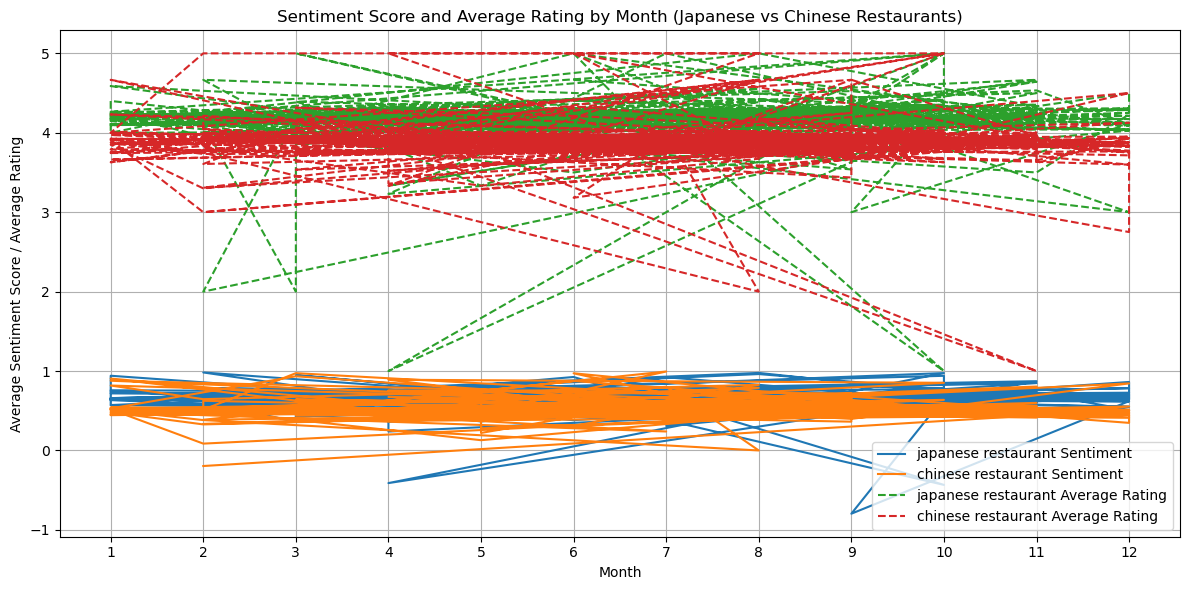

In [14]:
#better with comparison to average score given(rating), FAILED
from pyspark.sql.functions import month, year, avg
import matplotlib.pyplot as plt
import pandas as pd

# extract year and month from the date column
df_cleaned = df_filtered_with_vader_sentiment.withColumn("year", year("date"))
df_cleaned = df_cleaned.withColumn("month", month("date"))

# the average sentiment per month for each keyword (Japanese/Chinese)
df_monthly_sentiment = df_cleaned.groupBy("year", "month", "keyword").agg(
    avg("sentiment").alias("avg_sentiment")
)

# Calculate the monthly average ratings (assuming "score" is the rating)
df_monthly_rating = df_cleaned.groupBy("year", "month", "keyword").agg(
    avg("score").alias("avg_rating")
)

# Convert to Pandas for plotting
df_monthly_sentiment_pd = df_monthly_sentiment.toPandas()
df_monthly_rating_pd = df_monthly_rating.toPandas()

# Merge sentiment and rating data
df_merged = pd.merge(df_monthly_sentiment_pd, df_monthly_rating_pd, on=["year", "month", "keyword"])


plt.figure(figsize=(12, 6))


for keyword in df_merged['keyword'].unique():
    data = df_merged[df_merged['keyword'] == keyword]
    plt.plot(data['month'], data['avg_sentiment'], label=f"{keyword} Sentiment")


for keyword in df_merged['keyword'].unique():
    data = df_merged[df_merged['keyword'] == keyword]
    plt.plot(data['month'], data['avg_rating'], label=f"{keyword} Average Rating", linestyle="--")


plt.xlabel('Month')
plt.ylabel('Average Sentiment Score / Average Rating')
plt.title('Sentiment Score and Average Rating by Month (Japanese vs Chinese Restaurants)')
plt.legend()
plt.xticks(range(1, 13))  # Show months from 1 to 12
plt.grid(True)
plt.tight_layout()
plt.show()



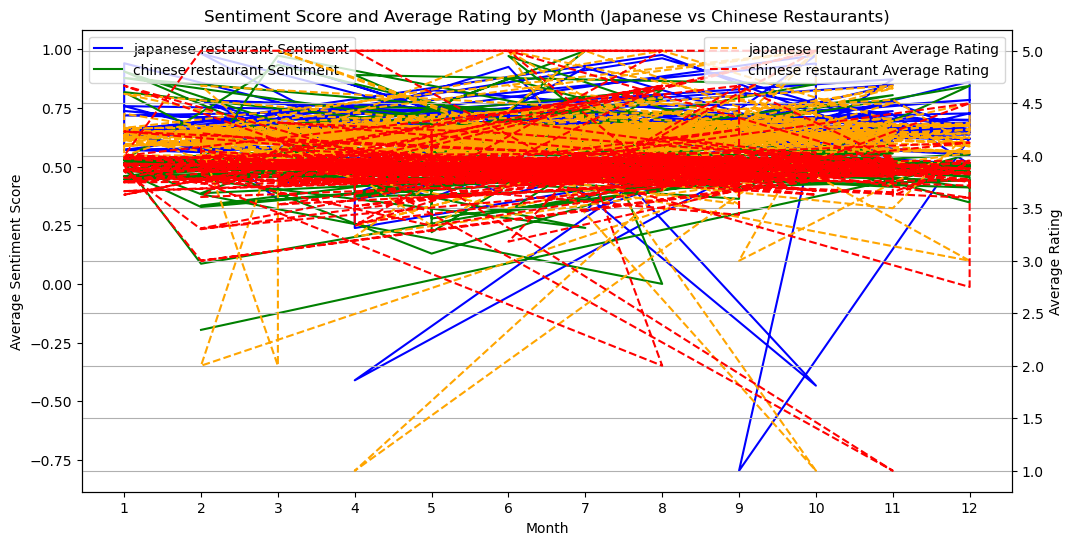

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import month, year, avg

# Assuming df_filtered_with_vader_sentiment is your cleaned DataFrame
df_cleaned = df_filtered_with_vader_sentiment.withColumn("year", year("date"))
df_cleaned = df_cleaned.withColumn("month", month("date"))

# Calculate the average sentiment per month for each keyword (Japanese/Chinese)
df_monthly_sentiment = df_cleaned.groupBy("year", "month", "keyword").agg(
    avg("sentiment").alias("avg_sentiment")
)

# Calculate the monthly average ratings (assuming "score" is the rating)
df_monthly_rating = df_cleaned.groupBy("year", "month", "keyword").agg(
    avg("score").alias("avg_rating")
)

# Convert to Pandas for plotting
df_monthly_sentiment_pd = df_monthly_sentiment.toPandas()
df_monthly_rating_pd = df_monthly_rating.toPandas()

# Merge sentiment and rating data
df_merged = pd.merge(df_monthly_sentiment_pd, df_monthly_rating_pd, on=["year", "month", "keyword"])

# Plot with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot sentiment scores on the first y-axis (range -1 to 1)
for keyword in df_merged['keyword'].unique():
    data = df_merged[df_merged['keyword'] == keyword]
    ax1.plot(data['month'], data['avg_sentiment'], label=f"{keyword} Sentiment", color='blue' if keyword == 'japanese restaurant' else 'green')

# Create a second y-axis for average rating (range 1 to 5)
ax2 = ax1.twinx()
for keyword in df_merged['keyword'].unique():
    data = df_merged[df_merged['keyword'] == keyword]
    ax2.plot(data['month'], data['avg_rating'], label=f"{keyword} Average Rating", linestyle="--", color='orange' if keyword == 'japanese restaurant' else 'red')

# Customize plot
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Sentiment Score', color='black')
ax2.set_ylabel('Average Rating', color='black')

# Show legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Title and grid
plt.title('Sentiment Score and Average Rating by Month (Japanese vs Chinese Restaurants)')
plt.xticks(range(1, 13))  # Show months from 1 to 12
plt.grid(True)

plt.show()



In [9]:
import sys
print(sys.executable)


/software/python-anaconda-2022.05-el8-x86_64/bin/python


In [10]:
!pip install prophet


Defaulting to user installation because normal site-packages is not writeable


In [11]:
from prophet import Prophet
print("Prophet is working!")


Prophet is working!


24/12/07 09:20:52 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /scratch/local/jobs/26672046/tmp3cwobym1/hxohkrl1.json
DEBUG:cmdstanpy:input tempfile: /scratch/local/jobs/26672046/tmp3cwobym1/gc6kgz1t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/ymusic7/.local/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66007', 'data', 'file=/scratch/local/jobs/26672046/tmp3cwobym1/hxohkrl1.json', 'init=/scratch/local/jobs/26672046/tmp3cwobym1/gc6kgz1t.json', 'output', 'file=/scratch/local/jobs/26672046/tmp3cwobym1/prophet_modelawc8qyyi/prophet_model-20241207092225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:22:26

<Figure size 1200x600 with 0 Axes>

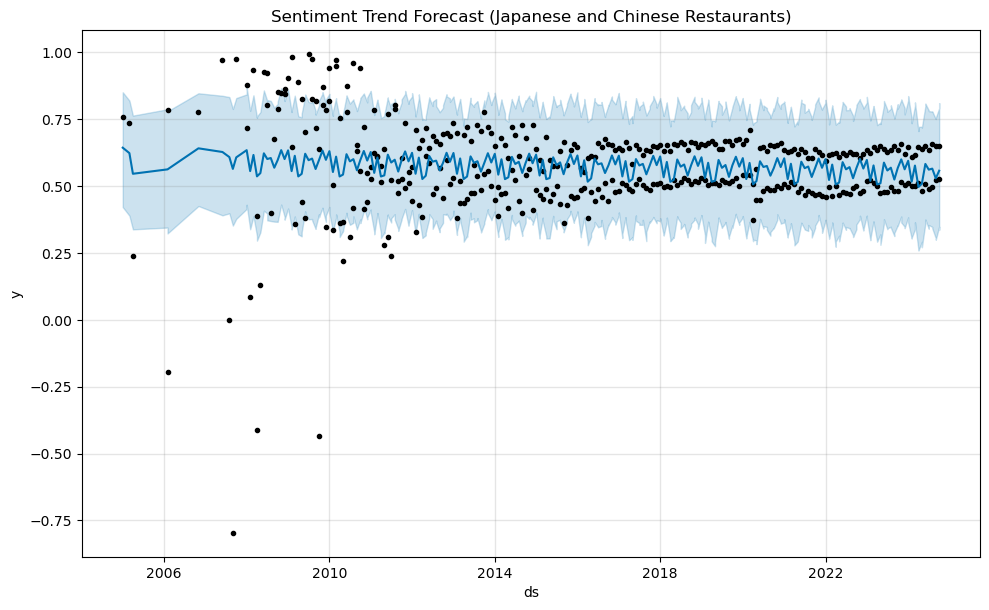

<Figure size 1200x600 with 0 Axes>

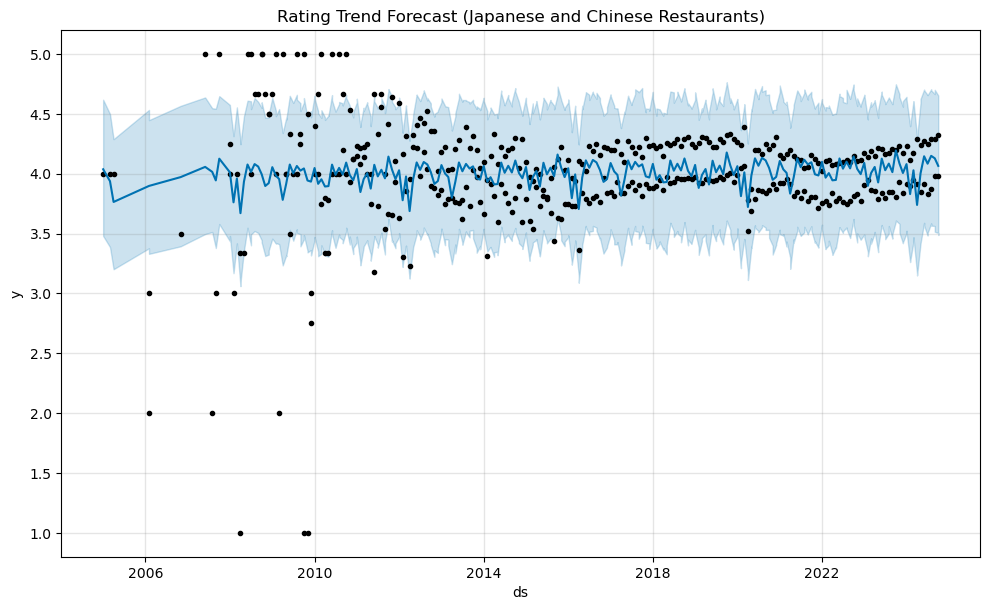

In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, month, avg
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Prophet Forecast") \
    .getOrCreate()

# Assuming your DataFrame is df_filtered_with_vader_sentiment
# Extract year and month from the 'date' column
df_cleaned = df_filtered_with_vader_sentiment.withColumn("year", year("date"))
df_cleaned = df_cleaned.withColumn("month", month("date"))

# Calculate the average sentiment per month for each keyword (Japanese/Chinese)
df_monthly_sentiment = df_cleaned.groupBy("year", "month", "keyword").agg(
    avg("sentiment").alias("avg_sentiment")
)

# Calculate the monthly average ratings (assuming "score" is the rating)
df_monthly_rating = df_cleaned.groupBy("year", "month", "keyword").agg(
    avg("score").alias("avg_rating")
)

# Convert to Pandas for plotting
df_monthly_sentiment_pd = df_monthly_sentiment.toPandas()
df_monthly_rating_pd = df_monthly_rating.toPandas()

# Merge sentiment and rating data
df_merged = pd.merge(df_monthly_sentiment_pd, df_monthly_rating_pd, on=["year", "month", "keyword"])

# Sentiment data for Prophet
sentiment_data = df_merged[['year', 'month', 'avg_sentiment', 'keyword']]

# Create a datetime column 'ds' combining year and month, and 'y' for average sentiment
sentiment_data['ds'] = pd.to_datetime(sentiment_data[['year', 'month']].assign(day=1))
sentiment_data = sentiment_data.rename(columns={'avg_sentiment': 'y'})

# Rating data for Prophet
rating_data = df_merged[['year', 'month', 'avg_rating', 'keyword']]

# For ds average rating
rating_data['ds'] = pd.to_datetime(rating_data[['year', 'month']].assign(day=1))
rating_data = rating_data.rename(columns={'avg_rating': 'y'})

# Define and fit the Prophet model for sentiment
sentiment_model = Prophet()
sentiment_model.fit(sentiment_data[['ds', 'y']])

# Forecast for sentiment
sentiment_forecast = sentiment_model.predict(sentiment_data[['ds', 'y']])

# Define and fit the Prophet model for rating
rating_model = Prophet()
rating_model.fit(rating_data[['ds', 'y']])

# Forecast for rating
rating_forecast = rating_model.predict(rating_data[['ds', 'y']])

# Plot Sentiment Trend Forecast
plt.figure(figsize=(12, 6))
sentiment_model.plot(sentiment_forecast)
plt.title('Sentiment Trend Forecast (Japanese and Chinese Restaurants)')

# Plot Rating Trend Forecast
plt.figure(figsize=(12, 6))
rating_model.plot(rating_forecast)
plt.title('Rating Trend Forecast (Japanese and Chinese Restaurants)')

plt.show()


In [31]:
from pyspark.sql.functions import year, month, avg
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# extract year and month from the date column
df_cleaned = df_filtered_with_vader_sentiment.withColumn("year", year("date"))
df_cleaned = df_cleaned.withColumn("month", month("date"))

# calculate average sentiment and ratings per month for each keyword
df_monthly_sentiment = df_cleaned.groupBy("year", "month", "keyword").agg(
    avg("sentiment").alias("avg_sentiment")
)
df_monthly_rating = df_cleaned.groupBy("year", "month", "keyword").agg(
    avg("score").alias("avg_rating")
)

# convert to pandas and merge
df_monthly_sentiment_pd = df_monthly_sentiment.toPandas()
df_monthly_rating_pd = df_monthly_rating.toPandas()
df_merged = pd.merge(df_monthly_sentiment_pd, df_monthly_rating_pd, on=["year", "month", "keyword"], how="outer")

# create a full date range
full_months = pd.date_range(start="2005-01-01", end="2024-12-01", freq='MS')
full_data = pd.DataFrame({
    'ds': full_months,
    'year': full_months.year,
    'month': full_months.month
})

# ensure all months are represented for each cuisine
complete_data = []
for cuisine in ['Japanese', 'Chinese']:
    cuisine_data = df_merged[df_merged['keyword'] == cuisine]
    cuisine_complete = pd.merge(full_data, cuisine_data, on=['year', 'month'], how='left')
    cuisine_complete['keyword'] = cuisine
    
    # interpolate missing values for smoother trends
    cuisine_complete['avg_sentiment'] = cuisine_complete['avg_sentiment'].interpolate(method='linear')
    cuisine_complete['avg_rating'] = cuisine_complete['avg_rating'].interpolate(method='linear')
    
    # fill remaining NaN with last valid observation
    cuisine_complete['avg_sentiment'] = cuisine_complete['avg_sentiment'].fillna(method='bfill').fillna(method='ffill')
    cuisine_complete['avg_rating'] = cuisine_complete['avg_rating'].fillna(method='bfill').fillna(method='ffill')

    complete_data.append(cuisine_complete)

df_merged_complete = pd.concat(complete_data)

# loop through cuisines
for cuisine in ['Japanese', 'Chinese']:
    sentiment_data = df_merged_complete[df_merged_complete['keyword'] == cuisine][['ds', 'avg_sentiment']].rename(columns={'avg_sentiment': 'y'})
    rating_data = df_merged_complete[df_merged_complete['keyword'] == cuisine][['ds', 'avg_rating']].rename(columns={'avg_rating': 'y'})

    # fit prophet for sentiment
    sentiment_model = Prophet()
    sentiment_model.fit(sentiment_data)
    sentiment_forecast = sentiment_model.predict(sentiment_model.make_future_dataframe(periods=0, freq='MS'))

    # fit prophet for rating
    rating_model = Prophet()
    rating_model.fit(rating_data)
    rating_forecast = rating_model.predict(rating_model.make_future_dataframe(periods=0, freq='MS'))

    # plot sentiment
    plt.figure(figsize=(12, 6))
    plt.plot(sentiment_data['ds'], sentiment_data['y'], marker='o', label=f"observed sentiment - {cuisine}")
    plt.plot(sentiment_forecast['ds'], sentiment_forecast['yhat'], label=f"forecast sentiment - {cuisine}")
    plt.title(f'sentiment trend forecast ({cuisine} restaurants)')
    plt.xlabel("year")
    plt.ylabel("sentiment")
    plt.legend()
    plt.grid(True)

    # plot rating
    plt.figure(figsize=(12, 6))
    plt.plot(rating_data['ds'], rating_data['y'], marker='o', label=f"observed rating - {cuisine}")
    plt.plot(rating_forecast['ds'], rating_forecast['yhat'], label=f"forecast rating - {cuisine}")
    plt.title(f'rating trend forecast ({cuisine} restaurants)')
    plt.xlabel("year")
    plt.ylabel("rating")
    plt.legend()
    plt.grid(True)

plt.show()



ValueError: Dataframe has less than 2 non-NaN rows.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /scratch/local/jobs/26672046/tmp3cwobym1/covbu79z.json
DEBUG:cmdstanpy:input tempfile: /scratch/local/jobs/26672046/tmp3cwobym1/guxeg5zi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/ymusic7/.local/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5634', 'data', 'file=/scratch/local/jobs/26672046/tmp3cwobym1/covbu79z.json', 'init=/scratch/local/jobs/26672046/tmp3cwobym1/guxeg5zi.json', 'output', 'file=/scratch/local/jobs/26672046/tmp3cwobym1/prophet_model6pt5z3f0/prophet_model-20241207100043.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:00:43 - cmdstanpy - INFO - Cha

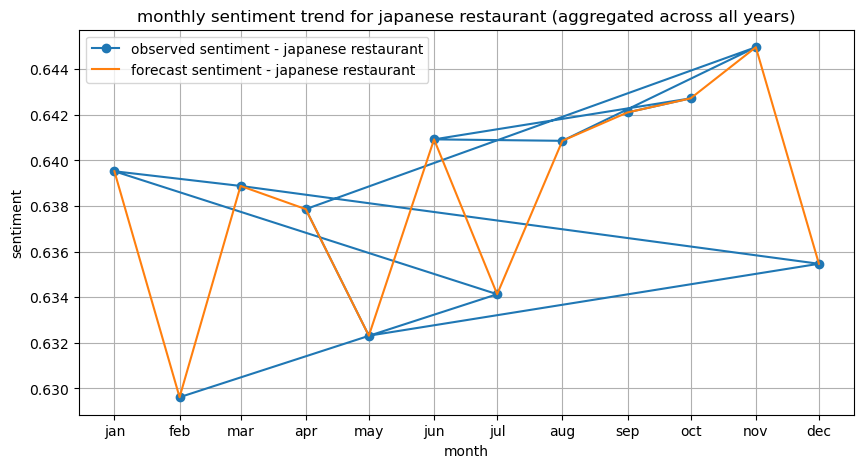

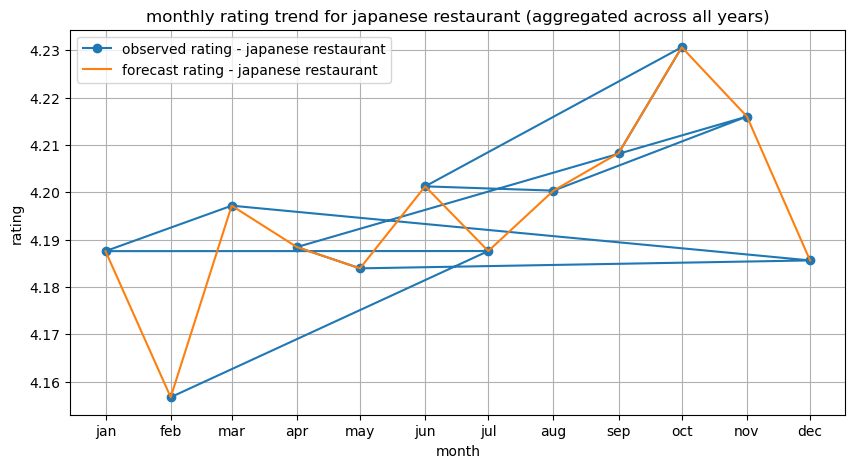

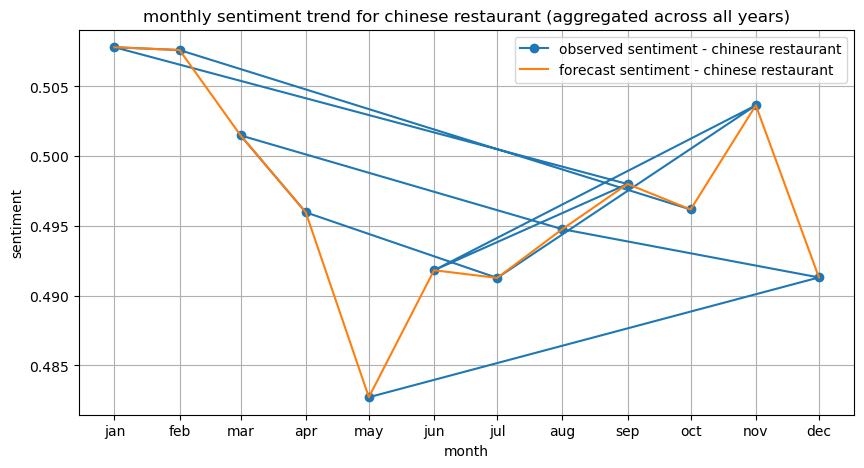

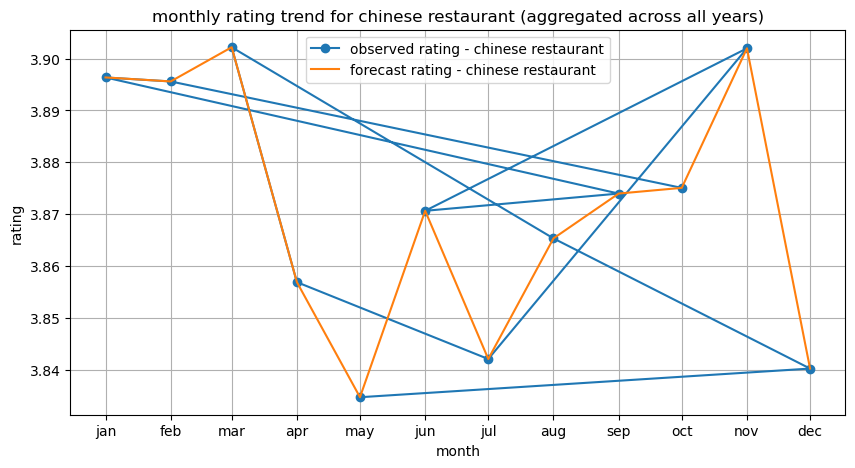

In [25]:
from pyspark.sql.functions import month, avg
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# group data by month and keyword, ignoring the year
df_cleaned = df_filtered_with_vader_sentiment.withColumn("month", month("date"))
df_monthly_avg = df_cleaned.groupBy("month", "keyword").agg(
    avg("sentiment").alias("avg_sentiment"),
    avg("score").alias("avg_rating")
)

# convert the grouped data to pandas
df_monthly_avg_pd = df_monthly_avg.toPandas()

# create a datetime column for prophet using only month
df_monthly_avg_pd['ds'] = pd.to_datetime(
    {'year': 2024, 'month': df_monthly_avg_pd['month'], 'day': 1}
)

# initialize dictionaries to store forecasts
sentiment_forecasts = {}
rating_forecasts = {}

for keyword in df_monthly_avg_pd['keyword'].unique():
    # filter data for each keyword
    sentiment_data = df_monthly_avg_pd[df_monthly_avg_pd['keyword'] == keyword][['ds', 'avg_sentiment']].rename(columns={'avg_sentiment': 'y'})
    rating_data = df_monthly_avg_pd[df_monthly_avg_pd['keyword'] == keyword][['ds', 'avg_rating']].rename(columns={'avg_rating': 'y'})

    # use prophet for sentiment
    sentiment_model = Prophet(yearly_seasonality=False)
    sentiment_model.add_seasonality(name='monthly', period=12, fourier_order=3)
    sentiment_model.fit(sentiment_data)
    sentiment_forecasts[keyword] = sentiment_model.predict(sentiment_model.make_future_dataframe(periods=0, freq='MS'))

    # use prophet for rating
    rating_model = Prophet(yearly_seasonality=False)
    rating_model.add_seasonality(name='monthly', period=12, fourier_order=3)
    rating_model.fit(rating_data)
    rating_forecasts[keyword] = rating_model.predict(rating_model.make_future_dataframe(periods=0, freq='MS'))

    # plot sentiment trends
    plt.figure(figsize=(10, 5))
    plt.plot(sentiment_data['ds'], sentiment_data['y'], marker='o', label=f"observed sentiment - {keyword}")
    plt.plot(sentiment_forecasts[keyword]['ds'], sentiment_forecasts[keyword]['yhat'], label=f"forecast sentiment - {keyword}")
    plt.title(f"monthly sentiment trend for {keyword} (aggregated across all years)")
    plt.xlabel("month")
    plt.ylabel("sentiment")
    plt.xticks(pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS'), 
               ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])
    plt.legend()
    plt.grid(True)

    # plot rating trends
    plt.figure(figsize=(10, 5))
    plt.plot(rating_data['ds'], rating_data['y'], marker='o', label=f"observed rating - {keyword}")
    plt.plot(rating_forecasts[keyword]['ds'], rating_forecasts[keyword]['yhat'], label=f"forecast rating - {keyword}")
    plt.title(f"monthly rating trend for {keyword} (aggregated across all years)")
    plt.xlabel("month")
    plt.ylabel("rating")
    plt.xticks(pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS'), 
               ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])
    plt.legend()
    plt.grid(True)

plt.show()



In [21]:
!pip install mkl


Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement mkl (from versions: none)
ERROR: No matching distribution found for mkl


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, month, avg, col



# convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# extract year and month from the date column
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# group by year, month, and keyword (Japanese/Chinese) and calculate average sentiment and rating
df_monthly_sentiment = df.groupby(['year', 'month', 'keyword']).agg({
    'sentiment': 'mean',
    'score': 'mean'
}).reset_index()

# separate the data for Japanese and Chinese restaurants
japanese_df = df_monthly_sentiment[df_monthly_sentiment['keyword'] == 'japanese restaurant'][['year', 'month', 'sentiment', 'score']]
chinese_df = df_monthly_sentiment[df_monthly_sentiment['keyword'] == 'chinese restaurant'][['year', 'month', 'sentiment', 'score']]

# combine 'year' and 'month' columns to create a 'date' column for both datasets
japanese_df['date'] = pd.to_datetime(japanese_df[['year', 'month']].assign(day=1))
chinese_df['date'] = pd.to_datetime(chinese_df[['year', 'month']].assign(day=1))

# arima Model for Sentiment Forecast (Japanese)
japanese_sentiment = japanese_df[['date', 'sentiment']].set_index('date')
arima_sentiment_japanese = ARIMA(japanese_sentiment['sentiment'], order=(5, 1, 0))  # ARIMA(p,d,q) parameters
fitted_arima_japanese = arima_sentiment_japanese.fit()

# Forecast sentiment for the next 12 months
forecast_sentiment_japanese = fitted_arima_japanese.forecast(steps=12)

# arima Model for Sentiment Forecast (Chinese)
chinese_sentiment = chinese_df[['date', 'sentiment']].set_index('date')
arima_sentiment_chinese = ARIMA(chinese_sentiment['sentiment'], order=(5, 1, 0))
fitted_arima_chinese = arima_sentiment_chinese.fit()

# Forecast sentiment for the next 12 months
forecast_sentiment_chinese = fitted_arima_chinese.forecast(steps=12)

# arima Model for Rating Forecast (Japanese)
arima_rating_japanese = ARIMA(japanese_sentiment['score'], order=(5, 1, 0))
fitted_arima_rating_japanese = arima_rating_japanese.fit()

# Forecast rating for the next 12 months
forecast_rating_japanese = fitted_arima_rating_japanese.forecast(steps=12)

# arima Model for Rating Forecast (Chinese)
chinese_rating = chinese_df[['date', 'score']].set_index('date')
arima_rating_chinese = ARIMA(chinese_rating['score'], order=(5, 1, 0))
fitted_arima_rating_chinese = arima_rating_chinese.fit()

# Forecast rating for the next 12 months
forecast_rating_chinese = fitted_arima_rating_chinese.forecast(steps=12)


plt.figure(figsize=(14, 8))

#Sentiment Forecast
plt.subplot(2, 1, 1)
plt.plot(japanese_sentiment.index, japanese_sentiment['sentiment'], label="Japanese Sentiment (Actual)", color='blue')
plt.plot(pd.date_range(start=japanese_sentiment.index[-1], periods=13, freq='M')[1:], forecast_sentiment_japanese, label="Japanese Sentiment (Forecast)", linestyle='--', color='blue')
plt.plot(chinese_sentiment.index, chinese_sentiment['sentiment'], label="Chinese Sentiment (Actual)", color='green')
plt.plot(pd.date_range(start=chinese_sentiment.index[-1], periods=13, freq='M')[1:], forecast_sentiment_chinese, label="Chinese Sentiment (Forecast)", linestyle='--', color='green')
plt.title('Sentiment Forecast (Japanese vs Chinese Restaurants)')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.legend()

# rating Forecast
plt.subplot(2, 1, 2)
plt.plot(japanese_sentiment.index, japanese_sentiment['score'], label="Japanese Rating (Actual)", color='blue')
plt.plot(pd.date_range(start=japanese_sentiment.index[-1], periods=13, freq='M')[1:], forecast_rating_japanese, label="Japanese Rating (Forecast)", linestyle='--', color='blue')
plt.plot(chinese_sentiment.index, chinese_sentiment['score'], label="Chinese Rating (Actual)", color='green')
plt.plot(pd.date_range(start=chinese_sentiment.index[-1], periods=13, freq='M')[1:], forecast_rating_chinese, label="Chinese Rating (Forecast)", linestyle='--', color='green')
plt.title('Rating Forecast (Japanese vs Chinese Restaurants)')
plt.xlabel('Date')
plt.ylabel('Rating')
plt.legend()

plt.tight_layout()
plt.show()


ImportError: libmkl_rt.so.1: cannot open shared object file: No such file or directory